<a href="https://colab.research.google.com/github/restrepo/COVID-19/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 data for Colombia

Use of [public Covid-19 in GitHub](https://github.com/CSSEGISandData/COVID-19) data from: 
[Center for Systems Science and Engineering (CSSE)](https://systems.jhu.edu/):

* Hongru Du, Lauren Gardner, and Ensheng Dong, An interactive web-based dashboard to track COVID-19 in real time, http://www.thelancet.com/infection Published:February 19, 2020, DOI:https://doi.org/10.1016/S1473-3099(20)30120-1

For examples of use of the data see Jupyter Notebook `covid19_analysis.ipynb`: [[local](./covid19_analysis.ipynb)] [[GitHub](https://github.com/restrepo/Covid-19/blob/master/covid_analysis.ipynb)] [[Colab](https://colab.research.google.com/github/restrepo/Covid-19/blob/master/covid_analysis.ipynb)]

[Official Colombia data](https://infogram.com/covid-2019-ins-colombia-1hnq41zg9ord63z)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import pandas as pd
import re
#See https://strftime.org/
import datetime

In [0]:
def date_range(date_start='2/23/20',date_end='3/03/20',date_step=1):
    dr=[]
    start = datetime.datetime.strptime(date_start, "%m/%d/%y")
    end = datetime.datetime.strptime(date_end, "%m/%d/%y")
    step = datetime.timedelta(days=date_step)
    while start <= end:
        #avoid leading zeroes: https://stackoverflow.com/a/2073189/2268280
        dr.append(start.strftime("%-m/%-d/%y"))
        start += step
    return dr
def get_infected(country,date_start=None,date_end=None,DataFrame=None,
      DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/',
      DataFile='master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
      ):
    '''
    Obtenga la lista de infectados de un país
     country: País
     date_start: Fecha inicial en el formato MM/DD/YY, e.g. '3/10/20' o None
     date_end  : Fecha final en el formato MM/DD/YY, e.g. '3/10/20' o None
     si alguna de las fechas esta en None se toma de los extremos del rango
     de fechas disponible
    '''
    if DataFrame is None:
        cva=pd.read_csv('{}{}'.format(data_source,data_file))
        cva=cva.reset_index(drop=True)
    else:
        cva=DataFrame.copy()

    d=[ c for c in cva.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]
    if not date_start:
        date_start=d[0]
    if not date_end:
        date_end=d[-1]
    dr=date_range(date_start=date_start,date_end=date_end)
    cvrg=cva[cva['Country/Region']==country].reset_index(drop=True)
    y=cvrg[dr].values.tolist()[0]
    return y

def dataframe_doubling(x,y,start_date,final_date):
    '''
    x: list of days
    y: list of infections
    '''
    sp=pd.DataFrame()
    if len(x)<3:
        print('WARNING: Not enough data: at least 3 days')
        return sp
    spd={'start_date':start_date,'final_date':final_date}
    for d in x[2:]:
        exp_fit = opt.curve_fit(exponential_model,x[:d],y[:d],p0=[1,0.4,3])
        spd['g']=exp_fit[0][1]
        N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
        if exponential_model(t0,N0,g,t0)==N0:
            Td=np.log(2)/g
            spd['N0']=exp_fit[0][0]
            spd['t0']=exp_fit[0][2]
            spd['Td']=Td
            spd['day']=d
            spd['infections']=y[d-1]
        sp=sp.append(spd,ignore_index=True)

    sp['day']=sp['day'].astype(int)
    sp['infections']=sp['infections'].astype(int)
    return sp

## Load data

In [0]:
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataFile='master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
cva=pd.read_csv('{}{}'.format(DataSource,DataFile))
cva=cva.reset_index(drop=True)

## Normalize data
Be sure to have only a row for country

In [5]:
def get_sum_series(cvn):
    cs=cvn.sum()
    cs['Province/State']='All'
    cs['Country/Region']=cvn['Country/Region'].unique()[0]
    cs['Lat']=round( cvn['Lat'].mean(),3 )
    cs['Long']=round( cvn['Long'].mean(),3 )
    return cs

cvo=pd.DataFrame()

multi_country=[]
for c in cva['Country/Region']:
    if c not in multi_country:
        cvn=cva[cva['Country/Region']==c].reset_index(drop=True)
        if cvn.shape[0]>1:
            multi_country.append(c)
            cvo=cvo.append(get_sum_series(cvn),ignore_index=True)
        else:
            cvo=cvo.append(cvn,sort=False)

cvo=cvo[cva.columns].reset_index(drop=True)

cv=cvo.copy()

cv.shape

(166, 64)

Special cases

In [0]:
sc=cva[cva['Province/State']=='Hong Kong'].reset_index(drop=True)
sc['Country/Region']='Hong Kong'
if sc.shape[0]==1:
    cv=cv.append(sc,sort=False)
    cv=cv.reset_index(drop=True)

In [7]:
d=[ c for c in cv.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]

#https://www.tutorialspoint.com/How-to-sort-a-Python-date-string-list
#updeted date
cv['tolist']=cv[d].values.tolist()

d.sort(key=lambda date: datetime.datetime.strptime(date, "%m/%d/%y"))

cv[:1]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,tolist
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411,"[2, 3, 5, 7, 8, 8, 14, 14, 14, 19, 19, 19, 19,..."


last update

In [8]:
dmax=d[-1]
dmax

'3/21/20'

## Fit to logistic or exponential model
See: 
* https://twitter.com/burkert_andreas/status/1239692655833071616
    * https://raw.githubusercontent.com/restrepo/Covid-19/master/covid-19.jpeg

* Method for Python explained in 
[Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d):

> While the logistic model describes an infection growth that is going to stop in the future, the exponential model describes an unstoppable infection growth. For example, if a patient infects 2 patients per day, after 1 day we’ll have 2 infections, 4 after 2 days, 8 after 3 and so on. The most generic exponential function is:

$$f(x,a,b,c)=a\operatorname{e}^{b(x-c)}\,.$$

Which can be [interpreted as](https://en.wikipedia.org/wiki/Doubling_time)
$$N(t)=N(t_0)\operatorname{e}^{g(t-t_0)}$$

or

$g = \dfrac{\ln\left(N(t)/N(t_0)\right)}{t-t_0}$

* $N(t)$ = the number of infections at time $t$
* $N(t_0)$ = the number of infections at time $t_0$
* $g$ = growth rate
* $t$ = time (usually in days)

Doubling time $T_d$:

$T_d = \dfrac{\ln(2)}{g}$

$T_d = (t-t_0)\dfrac{\ln(2)}{\ln\left(N(t)/N(t_0)\right)}$

For doubling times analysis for other countries see [Forbes](https://www.forbes.com/sites/startswithabang/2020/03/17/why-exponential-growth-is-so-scary-for-the-covid-19-coronavirus/#66dd44434e9b) - [Result](https://raw.githubusercontent.com/restrepo/Covid-19/master/img/doubling.jpg)



In [0]:
import numpy as np
from scipy import optimize as opt
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))    

Select a range of dates

# Colombia

### Select data for Colombia

In [27]:
NOT_OFFICIAL_UPDATE=False
c='Colombia'
max_forecast=1000
prediction=18
extra_days=16
start_day='3/9/20'
#dr=date_range(date_start=start_day,date_end=dmax)
#cvrg=cv[cv['Country/Region']==c].reset_index(drop=True)
#y=cvrg[dr].values.tolist()[0]
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
if NOT_OFFICIAL_UPDATE:
    today=input('Last infections: ')
    y.append(int(today))
x=range(1,len(y)+1)

Last infections: 231


### Logistic model for Colombia

In [28]:
logistic_fit = opt.curve_fit(logistic_model,x,y,p0=[2,10,100])
'logistic end: {} ± {} infections'.format(int(logistic_fit[0][2]),
                               int(np.sqrt(logistic_fit[1][2,2])))

'logistic end: 760 ± 481 infections'

### Exponential model for Colombia

Prepare data

In [29]:
exp_fit = opt.curve_fit(exponential_model,x,y,p0=[1,0.4,3])
try:
    Δb=np.sqrt(exp_fit[1][1,1])
except:
    Δb=0
'exponential `b`-fitted parameter: {}  ± {}'.format(exp_fit[0][1].round(3),Δb.round(3))

'exponential `b`-fitted parameter: 0.271  ± 0.017'

Prediction next day

In [30]:
exp_fit_co=exp_fit[0].copy()
exponential_model_co=lambda x: exponential_model(x, exp_fit_co[0],exp_fit_co[1],exp_fit_co[2]  )
infc=exponential_model_co(x[-1]+1  )
pinfc=exponential_model(x[-1]+1, exp_fit_co[0],exp_fit_co[1]+Δb,exp_fit_co[2]  )-infc
minfc=infc-exponential_model(x[-1]+1, exp_fit_co[0],exp_fit_co[1]-Δb,exp_fit_co[2]  )
next_day=r'next day:  $%g^{+%g}_{-%g}$' %(
                        int( infc ),int( pinfc ),int( minfc )  )
print('day {}:  {} infections'.format(x[-1]+1,next_day) )

day 15:  next day:  $312^{+114}_{-83}$ infections


Iterpretation in terms of
$$N(t)=N(t_0)\operatorname{e}^{g(t-t_0)}$$

In [31]:
N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
if exponential_model(t0,N0,g,t0)==N0:
    Td=np.log(2)/g
else:
    print('WARNING: N(t) interpretation not working')
    Td=None
if Td:
    dt=re.sub('\.0\s',' ', '(doubling time = {} days)'.format(Td.round(1)
        ))
    texmodel='N(t)=N(t_0)e^{t-t_0}='
    print('T_d →  {}'.format(dt))
else:
    texmodel=''
    dt=''

T_d →  (doubling time = 2.6 days)


Visualization

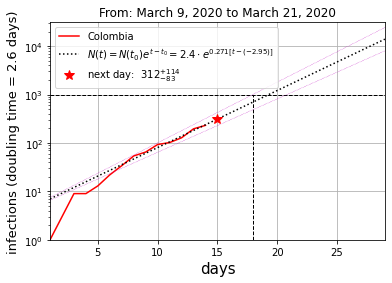

In [36]:
LOGISTIC=False
ERRORS=True
ylinlog='log'
xx=range(x[0],x[-1]+extra_days)
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%s%g\cdot e^{%g[t-(%g)]}$' %(texmodel,
                                             exp_fit[0][0].round(2),
                                             exp_fit[0][1].round(3),
                                             exp_fit[0][2].round(2)) )
if ERRORS:
    plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1]+Δb,exp_fit[0][2]),
         'm:',lw=0.5)
    plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1]-Δb,exp_fit[0][2]),
         'm:',lw=0.5)
if LOGISTIC:
    plt.plot(xx,
         logistic_model(xx,logistic_fit[0][0],logistic_fit[0][1],logistic_fit[0][2]),
         'c:',lw=1
          )

plt.hlines(max_forecast,xx[0],xx[-1],linestyles='--',lw=1)
plt.vlines(prediction,ymin,max_forecast,linestyles='--',lw=1)

plt.title('From: {} to {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y"),
    datetime.datetime.strptime(dmax,"%m/%d/%y").strftime("%B %-d, %Y") ) )
plt.plot(x[-1]+1,infc,'r*',markersize=10,
         label=next_day
         )

plt.legend(loc='upper left')
plt.xscale('linear')
plt.yscale(ylinlog)
plt.xlabel('days',size=15)
plt.ylabel('infections '+dt,size=13 )
if ylinlog=='linear':
    xmax=x[-1]+2
    ymax=y[-1]+infc+Δb
else:
    xmax=xx[-1]
    ymax=max_forecast+30000
plt.xlim(xx[0],xmax)
plt.ylim(ymin,ymax)
plt.grid()
plt.savefig('Colombia.png')


## Doubling time

In [37]:
sp=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


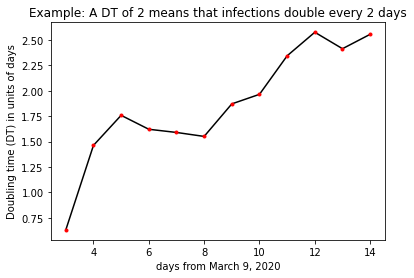

In [38]:
plt.plot(sp['day'],sp['Td'],'k-')
plt.plot(sp['day'],sp['Td'],'r.')
plt.title('Example: A DT of 2 means that infections double every 2 days')
plt.xlabel('days from {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y")
  ))
plt.ylabel('Doubling time (DT) in units of days')
plt.savefig('doublingtime.png')

### Other country

(27, 20000)

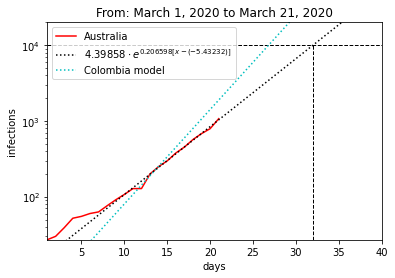

In [19]:
c='Australia'
max_forecast=10000
prediction=32#21
start_day='3/1/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=range(1,len(y)+1)
exp_fit = opt.curve_fit(exponential_model,x,y,p0=[1,0.4,3])

xx=range(x[0],x[-1]+20)
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%g\cdot e^{%g[x-(%g)]}$' %(exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) )

plt.plot(xx,exponential_model_co(xx),'c:',label='Colombia model')

plt.hlines(max_forecast,xx[0],xx[-1],linestyles='--',lw=1)
plt.vlines(prediction,ymin,max_forecast,linestyles='--',lw=1)

plt.title('From: {} to {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y"),
    datetime.datetime.strptime(dmax,"%m/%d/%y").strftime("%B %-d, %Y") ) ) 
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('days')
plt.ylabel('infections')
plt.xlim(xx[0],xx[-1])
plt.ylim(ymin,max_forecast+10000)

In [20]:
N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
if exponential_model(t0,N0,g,t0)==N0:
    Td=np.log(2)/g
else:
    print('WARNING: N(t) interpretation not working')
    Td=None
if Td:
    dt='(doubling time = {} days)'.format(Td.round(2))
    print('T_d →  {}'.format(dt))

T_d →  (doubling time = 3.36 days)


In [21]:
spa=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [22]:
c='Spain'
start_day='3/1/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=range(1,len(y)+1)
sps=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


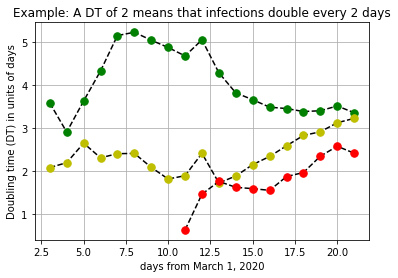

In [23]:
plt.plot(spa['day'],spa['Td'],'k--')
plt.plot(spa['day'],spa['Td'],'g.',markersize=15,label='Australia')
plt.plot(sps['day'],sps['Td'],'k--')
plt.plot(sps['day'],sps['Td'],'y.',markersize=15,label='Spain')
plt.plot(sp['day']+8,sp['Td'],'k--')
plt.plot(sp['day']+8,sp['Td'],'r.',markersize=15,label='Colombia')

plt.title('Example: A DT of 2 means that infections double every 2 days')
plt.xlabel('days from {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y")
  ))
plt.ylabel('Doubling time (DT) in units of days')
plt.savefig('doublingtime.png')
plt.grid()

### Last update

In [24]:
cv[cv['Country/Region']=='Colombia'][[dmax]]

,3/21/20
73,196


## Last official data from Colombia

In [0]:
import requests

r=requests.get('https://infogram.com/covid-2019-ins-colombia-1hnq41zg9ord63z')

head='"data":[[["ID de caso",'
tail=']]]'
js='{}{}{}'.format( head.split(':')[-1],
                 r.text.split(head)[-1].split(tail)[0],
                 tail
             )

df=pd.read_json(js)

coco=pd.DataFrame([l for l in df[range(1,df.columns[-1]+1)].values[0]],columns=df[0][0] )
coco['Fecha']=pd.to_datetime(coco['Fecha de diagnóstico'],format="%d/%m/%Y")

In [51]:
coco[coco['Fecha de diagnóstico'].str.contains('21/03')]

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Atención,Edad,Sexo,Tipo*,País de procedencia,Fecha
175,176,21/03/2020,Ibagué,casa,20 a 29,F,Importado,Estados Unidos,2020-03-21
176,177,21/03/2020,Cartagena,casa,20 a 29,M,En estudio,Colombia,2020-03-21
177,178,21/03/2020,Cartagena,casa,20 a 29,M,Importado,Estados Unidos,2020-03-21
178,179,21/03/2020,Cartagena,casa,40 a 49,F,En estudio,Colombia,2020-03-21
179,180,21/03/2020,Villa del Rosario,casa,20 a 29,M,Importado,España,2020-03-21
180,181,21/03/2020,Manizales,casa,20 a 29,F,Importado,Estados Unidos,2020-03-21
181,182,21/03/2020,Cúcuta,casa,40 a 49,F,Relacionado,Colombia,2020-03-21
182,183,21/03/2020,Cali,casa,40 a 49,F,Importado,Ecuador,2020-03-21
183,184,21/03/2020,Pereira,hospital,40 a 49,F,Importado,Estados Unidos,2020-03-21
184,185,21/03/2020,Palmira,casa,50 a 59,F,Relacionado,Colombia,2020-03-21
